<a href="https://colab.research.google.com/github/FatmaBuseBorlu/Dramer-Dataset/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from IPython import get_ipython
from IPython.display import display
import kagglehub
import shutil
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.signal.windows import hann
from scipy.signal import butter, lfilter
from scipy.signal import get_window

# Hann penceresi örneği (gerekirse kullanabilirsiniz)
hann_window = get_window('hann', 128)

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, random_split
    from torcheeg.datasets import DREAMERDataset
    from torcheeg import transforms
except ModuleNotFoundError as e:
    raise ModuleNotFoundError("PyTorch veya torcheeg kütüphanesi bulunamadı. Lütfen ortamınıza yükleyin veya alternatif bir yöntem kullanın.")


In [19]:
# Önce io_path klasörünü temizleyin
# shutil.rmtree('./dreamer_cnn_data', ignore_errors=True)

In [20]:
# Kaggle'dan veri setini indirin
path = kagglehub.dataset_download("phhasian0710/dreamer")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/phhasian0710/dreamer/versions/1


In [21]:
# Veri setini yükleyin ve ön işleme adımlarını uygulayın
dataset = DREAMERDataset(
    io_path='./dreamer_cnn_data',
    mat_path=f'{path}/DREAMER.mat',  # Kaggle'dan indirilen dosyanın yolu
    offline_transform=transforms.Compose([
        transforms.BaselineRemoval(),
        transforms.MeanStdNormalize(),
        transforms.To2d()
    ]),
    online_transform=transforms.ToTensor(),
    label_transform=transforms.Compose([
        transforms.Select('valence'),
        transforms.Binary(3.0)
    ]),
    chunk_size=128,
    baseline_chunk_size=128,
    num_baseline=61,
    num_worker=4
)

[2024-12-11 22:08:31] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to ./dreamer_cnn_data.
INFO:torcheeg:🔍 | Processing EEG data. Processed EEG data has been cached to ./dreamer_cnn_data.
[2024-12-11 22:08:31] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
INFO:torcheeg:⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
[PROCESS]:  52%|█████▏    | 12/23 [04:01<03:54, 21.28s/it]/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[PROCESS]: 100%|██████████| 23/23 [07:44<00:00, 20.21s/it]
[2024-12-11 22:20:01] INFO (torcheeg/Ma

In [22]:
# Veri setini eğitim ve test olarak ayırın
data_size = len(dataset)
train_size = int(0.8 * data_size)
test_size = data_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [23]:
# Veri yükleyicileri tanımlayın
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [24]:
# Basit bir EEG tabanlı CNN modeli
class EEGCNN(nn.Module):
    def __init__(self):
        super(EEGCNN, self).__init__()
        # Veri boyutu: (batch, 1, kanal=14, zaman=128)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        # MaxPool sonrası boyut: (batch, 64, 7, 64) -> 64*7*64=28672
        self.fc1 = nn.Linear(28672, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [25]:
# Modeli, kaybı ve optimizasyonu tanımlayın
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
test_accuracies = []

def train_one_epoch():
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.float().to(device)
        labels = labels.long().to(device)
        # inputs: (batch, channel=14, time=128)
        # Model 2D Conv bekliyor: (batch, 1, 14, 128)
        if inputs.dim() == 3:
            inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

In [26]:
# Test fonksiyonu
def test_model():
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)
            if inputs.dim() == 3:
                inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_labels, all_preds

In [27]:
# Eğitim döngüsü
epochs = 10
for epoch in range(epochs):
    train_loss = train_one_epoch()
    test_loss, test_acc, _, _ = test_model()
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch [1/10] - Train Loss: 0.6378, Test Loss: 0.6000, Test Acc: 0.6723
Epoch [2/10] - Train Loss: 0.5762, Test Loss: 0.5357, Test Acc: 0.7180
Epoch [3/10] - Train Loss: 0.5296, Test Loss: 0.5189, Test Acc: 0.7338
Epoch [4/10] - Train Loss: 0.4898, Test Loss: 0.4891, Test Acc: 0.7547
Epoch [5/10] - Train Loss: 0.4530, Test Loss: 0.4957, Test Acc: 0.7572
Epoch [6/10] - Train Loss: 0.4192, Test Loss: 0.4781, Test Acc: 0.7569
Epoch [7/10] - Train Loss: 0.3874, Test Loss: 0.5011, Test Acc: 0.7736
Epoch [8/10] - Train Loss: 0.3597, Test Loss: 0.5019, Test Acc: 0.7814
Epoch [9/10] - Train Loss: 0.3296, Test Loss: 0.5227, Test Acc: 0.7812
Epoch [10/10] - Train Loss: 0.3053, Test Loss: 0.5087, Test Acc: 0.7795


In [28]:
# Sonuçları tekrar test edip raporla
test_loss, test_acc, all_labels, all_preds = test_model()
print(f"Final Test Accuracy: {test_acc:.4f}")
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(all_labels, all_preds))

Final Test Accuracy: 0.7795
Confusion Matrix:
 [[4857 1832]
 [1949 8511]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.73      0.72      6689
           1       0.82      0.81      0.82     10460

    accuracy                           0.78     17149
   macro avg       0.77      0.77      0.77     17149
weighted avg       0.78      0.78      0.78     17149



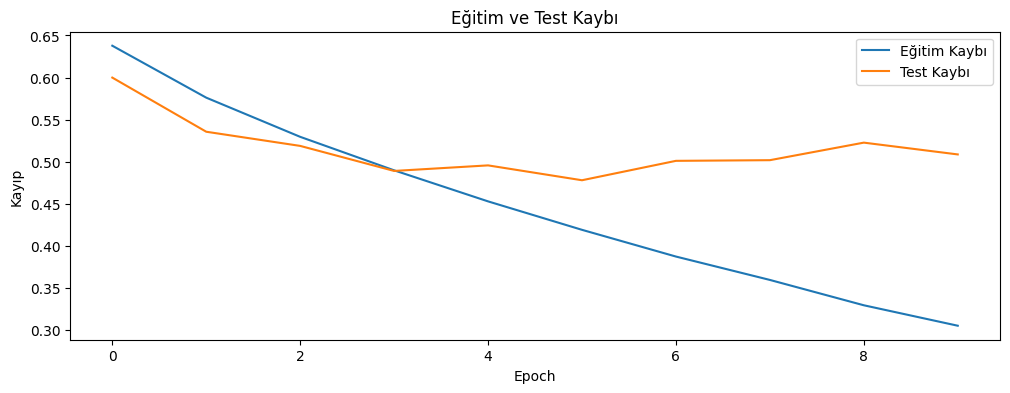

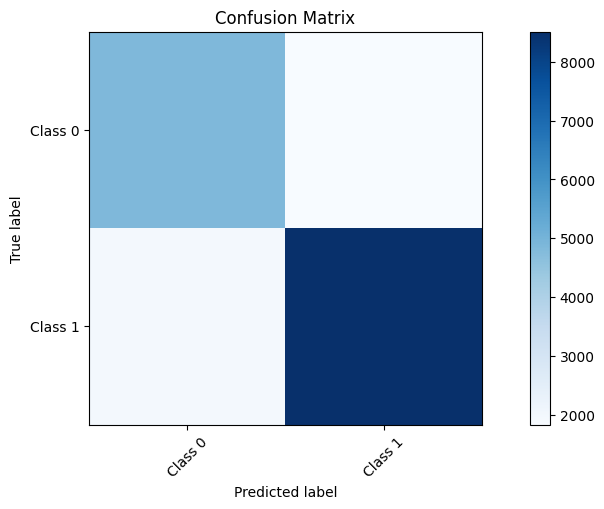

In [29]:
# Doğruluk görselleştirmesi
def plot_results(labels, preds, train_losses, test_losses):
    plt.figure(figsize=(12, 4))
    plt.plot(train_losses, label='Eğitim Kaybı')
    plt.plot(test_losses, label='Test Kaybı')
    plt.title('Eğitim ve Test Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    classes = ['Class 0', 'Class 1']
    cm = confusion_matrix(labels, preds)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_results(all_labels, all_preds, train_losses, test_losses)